# Train an NLP Model to Classify News Category

News Category Dataset is Taken From Kaggle (link below, download the .csv from the website):
https://www.kaggle.com/datasets/1f9e801c614a34d5c4ca204dc8d324e661f9575fe7749177a291efc833aa445f?resource=download
(if you got this notebook from my GitHub Repo, the .csv is already in the folder)

In this notebook, we will focus on training a news category classifier with the data above. We will not go too much into the details of text pre-processing, optimizing and fine-tuning the model hyperparameters as this GitHub Repo's main aim is to demonstrate how to eventually create a Web App from an NLP model to predict text. (You can imagine the Web App will have a large text field form for the user to enter some text before the prediction is given). 

More emphasis will hence be given to how to store the model into a file and then retrieve it for usage in a Web App (separate from this notebook), how to write the Web App and how to deploy it onto the cloud for other people to use!

In [1]:
# relevant imports, remember to do a pip install if you do not already have the libraries installed
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter # to plot word count graph for EDA later
import nltk # for NLP tasks
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords # for pre-processing of text to remove common words
stopwords = stopwords.words('english')
from nltk.stem import WordNetLemmatizer # for pre-processing of text (lemmatize text, i.e. converting a word to its base form)
from sklearn.feature_extraction.text import TfidfVectorizer # for pre-processing of text
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC # chosen model to train
from sklearn import metrics # for measuring accuracy
import pickle # to store model 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory Data Analysis and Pre-processing

First we load in the data and do some EDA and basic pre-processing of text.

In [2]:
df_raw = pd.read_csv("NewsCategorizer.csv")
df_raw.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


To make things simple, we will just use 2 columns, the 'category' of the news as well as its 'short_description'. i.e. We will just be training the model to predict the category of the news from the 'short_description'. Of course, other more complicated implementations can attempt to extract the full text from the website in the 'links' column to train the model. But let's keep things simple.

In [3]:
df = df_raw[['category', 'short_description']]
df.head()

,category,short_description
0,WELLNESS,Resting is part of training. I've confirmed wh...
1,WELLNESS,Think of talking to yourself as a tool to coac...
2,WELLNESS,The clock is ticking for the United States to ...
3,WELLNESS,"If you want to be busy, keep trying to be perf..."
4,WELLNESS,"First, the bad news: Soda bread, corned beef a..."


As can be seen below, there are 10 categories and they equally distributed among the whole dataset, nice!

In [4]:
categories = df['category'].unique()
print(categories)
df['category'].value_counts()

['WELLNESS' 'POLITICS' 'ENTERTAINMENT' 'TRAVEL' 'STYLE & BEAUTY'
 'PARENTING' 'FOOD & DRINK' 'WORLD NEWS' 'BUSINESS' 'SPORTS']


WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: category, dtype: int64

Here we clean the dataset (i.e. the 'short_description' column) by removing stopwords, punctuation, underscores and digits. Stopwords simply means common English words that is not specific to any news category e.g. the, it, he, I, myself. We do not want these words in the dataset.

In [5]:
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords)) # stopwords variable was defined at the import section earlier
df['short_description'] = df['short_description'].str.lower().replace([r'\|', RE_stopwords], ['',''], regex=True) # remove stopwords
df['short_description'] = df['short_description'].str.replace(r'[^\w\s]+', '').replace('_', '') # remove punctuation
df['short_description'] = df['short_description'].str.replace('_', '') # remove underscores
df['short_description'] = df['short_description'].str.replace(r"[0-9]+", "", regex=True)  # remove digits
df['short_description'] = df['short_description'].str.replace(r'\b[a-zA-Z]\b', '', regex=True) 

C:\Users\user\AppData\Local\Temp/ipykernel_14476/4002449389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_description'] = df['short_description'].str.lower().replace([r'\|', RE_stopwords], ['',''], regex=True) # remove stopwords
C:\Users\user\AppData\Local\Temp/ipykernel_14476/4002449389.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['short_description'] = df['short_description'].str.replace(r'[^\w\s]+', '').replace('_', '') # remove punctuation
C:\Users\user\AppData\Local\Temp/ipykernel_14476/4002449389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Next, we tokenize the words and perform text lemmatization, i.e. converting a word to its base form using the NLTK library.

In [6]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['short_description'] = df['short_description'].apply(lemmatize_text).str.join(" ")

C:\Users\user\AppData\Local\Temp/ipykernel_14476/771174075.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_description'] = df['short_description'].apply(lemmatize_text).str.join(" ")


Let's take a look at some of the text from the 'WELLNESS' and 'TRAVEL' categories to get a feel for the cleaned data. We print out the first few rows. Since we have processed the data to remove stopwords and punctuations etc., the sentences are not going to flow smoothly.

In [7]:
df[df['category']=='WELLNESS']['short_description'].values[:5]

array(['resting part training confirmed sort already knew built running streak built hard workout three five day week lot cross training physical therapy foam rolling also confirmed stubborn',
       'think talking tool coach challenge narrate experience case treat respect may find enjoy company',
       'clock ticking united state find cure team working study dr francisco lopera',
       'want busy keep trying perfect want happy focus making difference',
       'first bad news soda bread corned beef beer highly nutritious meal make luck irish would'],
      dtype=object)

In [8]:
df[df['category']=='TRAVEL']['short_description'].values[:5]

array(['discussion mccandless life either reading book watching film hearing passing information',
       'woke condition turn poke head see could travel horizon contrast thick whiteout slight shadow tent could see blizzard flying past u',
       'traveler going love one',
       'currently live los angeles way new york city two large selffocused metropolitan megacities london london favorite city world far',
       'walked across israel bicycled across burma piloted fishing boat laotian mekong driven land rover across america prove point traveling light trekked around world six week luggage bag kind'],
      dtype=object)

## Visualize How the Words are Distributed in Different Categories

Here we extract the words from each category, and from all the rows, then we count the number of occurrences of each word using the Counter() function we imported earlier. We then plot out the frequency of the 10 most common words for each category. We see some common words repeated across the categories, ideally it would be also good to add to the stopwords list words like 'one', 'time', 'year', 'like' as they seem to appear across all categories. However, the tfidf word vectorizer that we will be using later to vectorize the words will take care of that.

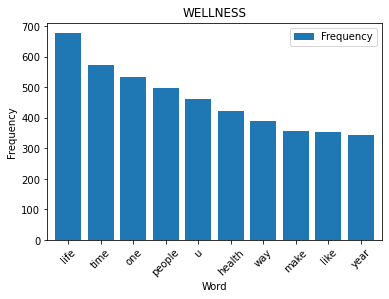

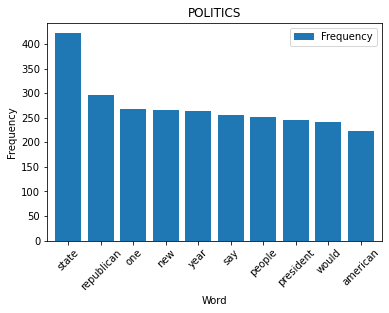

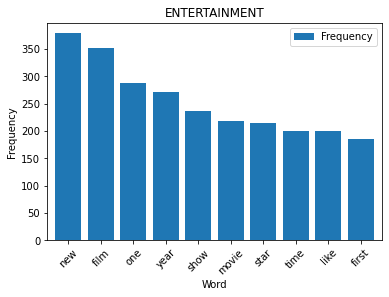

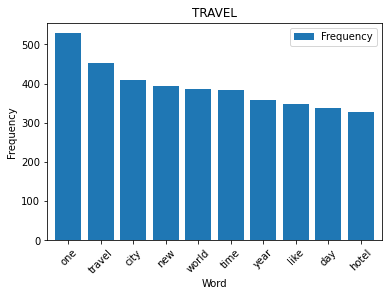

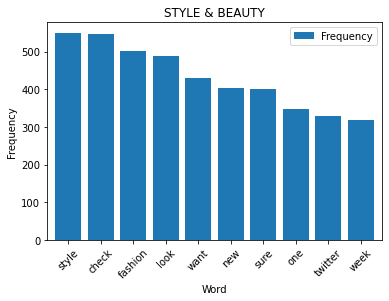

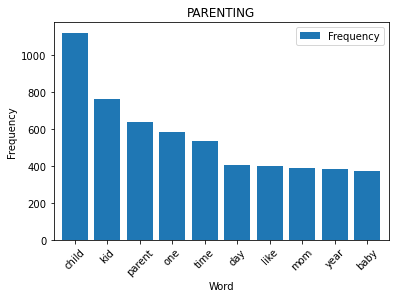

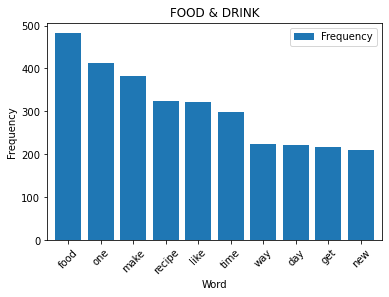

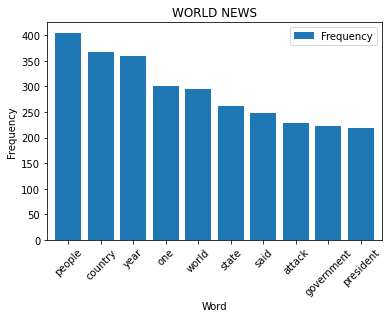

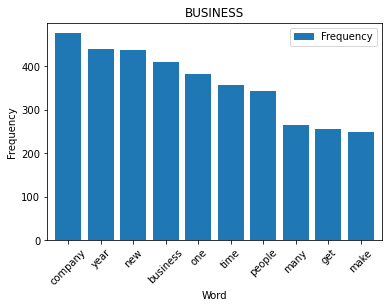

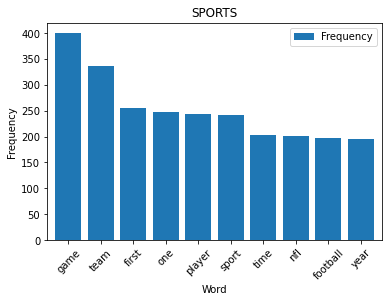

In [9]:
top_N = 10

for category in categories:
    words = df[df['category']==category]['short_description'].str.cat(sep=' ').split()

    # generate DF out of Counter
    rslt = pd.DataFrame(Counter(words).most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    # plot
    rslt.plot.bar(rot=45, width=0.8)
    plt.ylabel('Frequency')
    plt.title(category)
    plt.show()

We have now prepared our text data for training. As usual, the features (text) will be stored in the X variable, while the labels (category) will be stored in y.

In [10]:
X = df["short_description"]
y = df["category"]
print(X.head())
print(y.head())

0    resting part training confirmed sort already k...
1    think talking tool coach challenge narrate exp...
2    clock ticking united state find cure team work...
3    want busy keep trying perfect want happy focus...
4    first bad news soda bread corned beef beer hig...
Name: short_description, dtype: object
0    WELLNESS
1    WELLNESS
2    WELLNESS
3    WELLNESS
4    WELLNESS
Name: category, dtype: object


## Split into Train/Test Data and Vectorize the Text with TfidfVectorizer

We need to convert our text into vectors (meaningful representation of numbers) with a vectorizer, as our model can only deal with numbers, not alphabets. First, as with any machine learning task, we split our data into 2 groups of rows, the train and test sets using the train_test_split() function before vectorizing it.

### Term Frequency Inverse Document Frequency

Then we we use a **TfidfVectorizer**, Tfidf stands for 'Term Frequency Inverse Document Frequency'. Basically when this vectorizer is fitted on our data, it takes note of all terms/vocabulary (i.e. all the words and phrases involved) present in the text that we give it. (I have chosen to fit it with single words and also phrases of 2 words using the ngram_range = (1,2) parameter in the code below). It then converts each of the text (each row in the 'short_description' column) into a vector with corresponding numbers that account for the frequency of each of the terms involved. 

**'Term Frequency'** means the larger the number, the higher the frequency of the term in the text. 

Importantly, it factors in the **'Inverse Document Frequency'**. If the term appears many times in the text of a particular category, it might be a very common word (such as 'one', 'time', 'year' as seen earlier) which appears in many documents (i.e. many of the rows of text). Hence this term would not play an important role in identifying the category of text. By dividing each term's frequency by document frequency (i.e. the number of rows of text where it appears in), we can account for this and give a lesser weight to the common words. Feel free to read up more on TfidfVectorizer yourself.

### Fit on Train Data, Transform both Train and Test Data

The tfidf_vectorizer was uniquely fitted on *only* our training data to note all the terms involved, we then transform the training data into vectors which account for the frequency of this terms. This is done by the fit_transform() function below (two steps are involved here). We then use the same model to transform the test data into vectors. We do NOT fit it on the test data as the test data is meant to simulate user input of text for cateogry prediction, and the vectorizer is already fitted well before the user enters any input. Similarly, we will eventually need the tfidf_vectorizer in our Web App later to transform the phrases that we will type into the Web App into vectors, before using our trained model for prediction.

In [23]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=False, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words=stopwords)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [24]:
# Print the last 20 features, notice that they are made up of single words and also phrases of 2 words
features = tfidf_vectorizer.get_feature_names()[-20:]
features.sort()
features

['être',
 'être one',
 'île',
 'île de',
 'övertorneå',
 'övertorneå northern',
 'öztürk',
 'öztürk université',
 'über',
 'über cutie',
 'über mom',
 'übertalented',
 'übertalented smith',
 'łowicz',
 'łowicz people',
 'ﬁx',
 'ﬁx world',
 'ﬁx ﬁx',
 'ﬂavors',
 'ﬂavors texture']

## Train and Fit LinearSVC Model

The accuracy we get here is 70+%, not bad considering it was a very basic Linear Support Vector Classification model without any deep learning involved, and without any tuning of model hyperameters. Also we are only training on the 'short_description' of the news with some very basic pre-processing. Feel free to improve on the model by fine-tuning some of its parameters and do more advanced text pre-processing!

In [25]:
svc_classifier = LinearSVC()

# Fit the classifier to the training data
svc_classifier.fit(tfidf_train,y_train)

# Create the predicted categories
pred = svc_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.723


## Test the Model with Some Text

Here comes the fun part. Let's now test the model with some text! We create a function that takes in the text, vectorize it by using the transform() function of the tfidf_vectorizer that was fitted on our training data earlier, and use the svc_classifier model that was trained earlier to predict the news category and print it out.

In [14]:
def predict_topic(text):
    result = svc_classifier.predict(tfidf_vectorizer.transform([text]))
    return(result[0])

As a reminder these are the categories involved.

In [15]:
categories

array(['WELLNESS', 'POLITICS', 'ENTERTAINMENT', 'TRAVEL',
       'STYLE & BEAUTY', 'PARENTING', 'FOOD & DRINK', 'WORLD NEWS',
       'BUSINESS', 'SPORTS'], dtype=object)

In [16]:
predict_topic("cycle around London")

'TRAVEL'

In [17]:
predict_topic("fans were cheering at the stadium")

'SPORTS'

In [18]:
predict_topic("he scored a goal")

'SPORTS'

In [19]:
predict_topic("laughter is the best medicine")

'WELLNESS'

In [20]:
predict_topic("enjoying a burger with fries")

'FOOD & DRINK'

## Save the Model and Tfidf Vectorizer for Web App Usage Later

### Pickle library in Python

The pickle library in Python allows us to save Python objects into files in our local storage, using the pickle.dump() function. We can then load it into a Python object using another Python program using the pickle.load() function and use it just like how we have used it in this program for prediction.

Our svc_classifier model has been fitted and trained earlier. Note that we are saving both this trained model (with filename 'classifier.pkl') AND the tfidf_vectorizer (with filename 'tfidf_vectorizer.pkl'). We will load this model and vectorizer in our Python program ('app.py' file) for our Flask Python Web App to use it for predictions in the app later.

### Remember to save the tfidf_vectorizer object as well

Why are we saving the tfidf_vectorizer as well? Remember that the tfidf_vectorizer was uniquely fitted on our training data and its feature_names was derived from the words and phrases in our training data. We then use it to transform the training data AND the testing data to vectorizer the text. (We did not fit it on our testing data because we were not supposed to, if you have forgotten, you can go back to the section above to read it again.) Similarly, we will need the tfidf_vectorizer in our Web App later to transform text that we will type into the Web App into vectors, before the svc_classifier works on it to predict the news category.

### Save them to these filepaths

The filepaths of the saved model and vectorizer below are 'news_category_classifier_webapp/model/classifier.pkl' and 'news_category_classifier_webapp/model/tfidf_vectorizer.pkl' If you are using this notebook from my entire GitHub Repo without changing any of the folder structure, you need not change the filepath for the Web App usage later.

In [21]:
with open('news_category_classifier_webapp/model/classifier.pkl', 'wb') as file:
    pickle.dump(svc_classifier, file)
    
with open('news_category_classifier_webapp/model/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)